# Imports

In [1]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita una versión > 3.5.1 que soporte float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.5.3


In [2]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.4 MB/s eta 0:00:00
time: 368 µs (started: 2023-02-26 13:11:21 +00:00)


In [3]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense,
    Dropout, Input, Concatenate, GlobalAveragePooling2D
)
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.57 s (started: 2023-02-26 13:11:21 +00:00)


In [4]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 881
ETL_DATASET = 'etl_8G'
DNN_NAME = 'DenseNet121'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular' 

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/' \
            + TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print()
print('versión Keras:', keras.__version__)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_{}/splits/regular_otsu/

versión Keras: 2.11.0
time: 1.1 ms (started: 2023-02-26 13:11:24 +00:00)


In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 21.6 s (started: 2023-02-26 13:11:24 +00:00)


# Funciones

In [6]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for training and validation images
    '''
    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_8G.npz'
        train_name_labels = 'train_labels_8G.npz'
        val_name_img = 'val_imgs_8G.npz'
        val_name_labels = 'val_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_8G.npz'
        train_name_labels = 'train_inv_labels_8G.npz'
        val_name_img = 'val_inv_imgs_8G.npz'
        val_name_labels = 'val_inv_labels_8G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_8G.npz'
        test_name_labels = 'test_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_8G.npz'
        test_name_labels = 'test_inv_labels_8G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):

    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_DenseNet121_8G = keras.applications.DenseNet121(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_DenseNet121_8G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    #-----------------------------------------------------------
    # Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
    #-----------------------------------------------------------

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG,
               USE_DATA_AUG, DNN_NAME, ETL_DATASET):
    '''Guardar el modelo en disco duro
    
    Args:
        - SIZE: 64, 96, 112 ó 127
        - TFM_PATH = Ruta en drive a la carpeta del TFM
        - custom_model = Modelo de Deep Learning
        - TYPE_IMG = regular o inverted
        - USE_DATA_AUG = sin_DA o con_DA
        - DNN_NAME= Deep Neural Network's name, like DenseNet121.
    ''' 
    MODEL_NAME = f'model_{DNN_NAME.lower()}_{ETL_DATASET.lower()}_imgs{SIZE}_' \
                + TYPE_IMG +'__OTSU.h5'

    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/otsu_reg/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH)

    print(f'------ Model Saved in {WEIGHTS_PATH}')


time: 12.1 ms (started: 2023-02-26 13:11:46 +00:00)


# Imgs 64x64

- Test Accuracy: 0.7619853615760803
- Test Loss: 1.0735281705856323
- time: 54min 27s
- F1 score: 0.7620134205701014
- Precision score: 0.7789114977685294
- Recall:  0.7619853355893965
- Epoch: 50/50




## Cargar la imágenes

In [8]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_64/splits/regular_otsu/
time: 1.21 ms (started: 2023-02-26 13:12:04 +00:00)


In [9]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 10.1 s (started: 2023-02-26 13:12:05 +00:00)


In [10]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 64, 64, 1) and labels: (106380,)

- val images: (21276, 64, 64, 1) and labels: (21276,)


time: 963 µs (started: 2023-02-26 13:12:15 +00:00)


## Preparar el modelo

In [11]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

29084464/29084464 [==============================] - 3s 0us/step
time: 9.71 s (started: 2023-02-26 13:12:15 +00:00)


In [12]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['concatenate[0][0]']            
                                                                                              

## Entrenar modelo

In [13]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 81s 20ms/step - loss: 5.4572 - sparse_categorical_accuracy: 0.1089 - val_loss: 4.5987 - val_sparse_categorical_accuracy: 0.2127
Epoch 2/50
3325/3325 [==============================] - 64s 19ms/step - loss: 4.0612 - sparse_categorical_accuracy: 0.3185 - val_loss: 3.7811 - val_sparse_categorical_accuracy: 0.3561
Epoch 3/50
3325/3325 [==============================] - 64s 19ms/step - loss: 3.3657 - sparse_categorical_accuracy: 0.4397 - val_loss: 3.2668 - val_sparse_categorical_accuracy: 0.4449
Epoch 4/50
3325/3325 [==============================] - 65s 19ms/step - loss: 2.8984 - sparse_categorical_accuracy: 0.5189 - val_loss: 2.9092 - val_sparse_categorical_accuracy: 0.4962
Epoch 5/50
3325/3325 [==============================] - 65s 20ms/step - loss: 2.5559 - sparse_categorical_accuracy: 0.5726 - val_loss: 2.6421 - val_sparse_categorical_accuracy: 0.5374
Epoch 6/50
3325/3325 [==============================] - 66s 20ms/step - loss: 2.

In [14]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.97 s (started: 2023-02-26 14:06:54 +00:00)


In [15]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 9s 15ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7619853615760803
- Test Loss: 1.0735281705856323
- time: 
- F1 score: 0.7620134205701014
- Precision score: 0.7789114977685294
- Recall:  0.7619853355893965
- Epoch: 
*********************************************************************************************************************************
time: 17.2 s (started: 2023-02-26 14:06:56 +00:00)


## Graficando

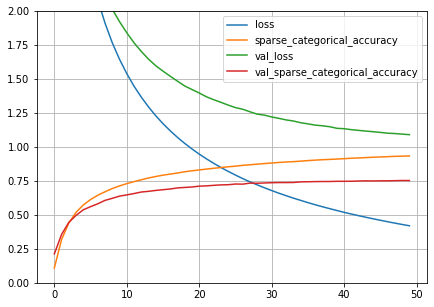

time: 230 ms (started: 2023-02-26 14:07:13 +00:00)


In [16]:
plot_loss(history)

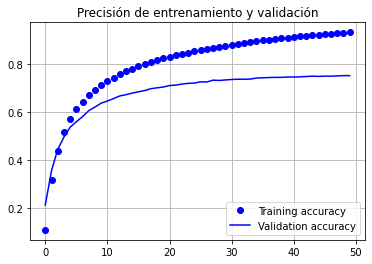

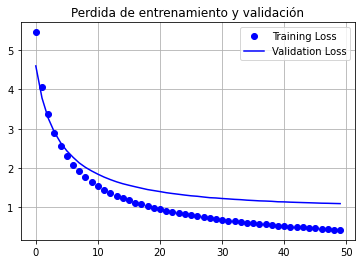

time: 240 ms (started: 2023-02-26 14:07:13 +00:00)


In [17]:
show_history(history)

In [18]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/regular/otsu_reg/model_densenet121_etl_8g_imgs64_regular__OTSU.h5
time: 4.65 s (started: 2023-02-26 14:07:13 +00:00)


# Imgs 96x96

- Test Accuracy: 0.8084461092948914
- Test Loss: 0.8422393798828125
- time: 59min 42s
- F1 score: 0.8088606380295006
- Precision score: 0.8207405500579235
- Recall:  0.8084461364918217
- Epoch: 50/50


## Cargar las imágenes

In [19]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_96/splits/regular_otsu/
time: 660 µs (started: 2023-02-26 14:07:18 +00:00)


In [20]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 9.42 s (started: 2023-02-26 14:07:18 +00:00)


In [21]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 96, 96, 1) and labels: (106380,)

- val images: (21276, 96, 96, 1) and labels: (21276,)

time: 1.45 ms (started: 2023-02-26 14:07:27 +00:00)


## Preparar el modelo

In [22]:
custom_model2 = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 2.94 s (started: 2023-02-26 14:07:27 +00:00)


In [23]:
print(custom_model2.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 96, 96, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 102, 102, 3)  0          ['concatenate_1[0][0]']          
 D)                                                                                         

## Entrenar modelo

In [24]:
history2 = train_model(custom_model2, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 82s 23ms/step - loss: 5.1451 - sparse_categorical_accuracy: 0.1470 - val_loss: 4.1428 - val_sparse_categorical_accuracy: 0.2915
Epoch 2/50
3325/3325 [==============================] - 72s 22ms/step - loss: 3.5417 - sparse_categorical_accuracy: 0.4116 - val_loss: 3.2504 - val_sparse_categorical_accuracy: 0.4520
Epoch 3/50
3325/3325 [==============================] - 73s 22ms/step - loss: 2.8131 - sparse_categorical_accuracy: 0.5414 - val_loss: 2.7291 - val_sparse_categorical_accuracy: 0.5372
Epoch 4/50
3325/3325 [==============================] - 73s 22ms/step - loss: 2.3539 - sparse_categorical_accuracy: 0.6148 - val_loss: 2.3873 - val_sparse_categorical_accuracy: 0.5876
Epoch 5/50
3325/3325 [==============================] - 72s 22ms/step - loss: 2.0328 - sparse_categorical_accuracy: 0.6659 - val_loss: 2.1392 - val_sparse_categorical_accuracy: 0.6246
Epoch 6/50
3325/3325 [==============================] - 73s 22ms/step - loss: 1.

In [25]:
test_images2, test_labels2 = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.71 s (started: 2023-02-26 15:07:14 +00:00)


In [26]:
show_metrics(custom_model2, test_images2, test_labels2)

444/444 [==============================] - 10s 17ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8084461092948914
- Test Loss: 0.8422393798828125
- time: 
- F1 score: 0.8088606380295006
- Precision score: 0.8207405500579235
- Recall:  0.8084461364918217
- Epoch: 
*********************************************************************************************************************************
time: 18.7 s (started: 2023-02-26 15:07:16 +00:00)


## Graficando

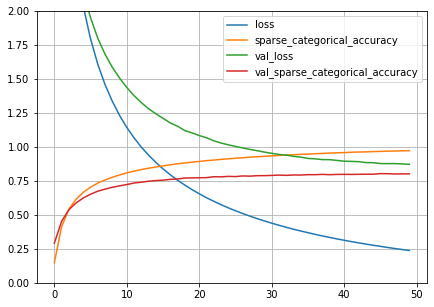

time: 152 ms (started: 2023-02-26 15:07:35 +00:00)


In [27]:
plot_loss(history2)

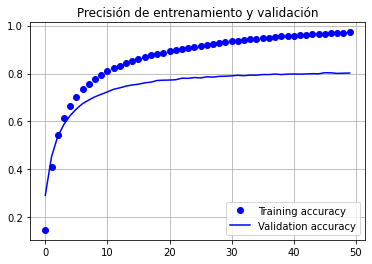

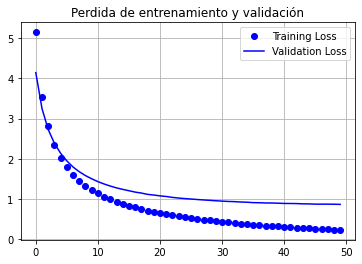

time: 250 ms (started: 2023-02-26 15:07:35 +00:00)


In [28]:
show_history(history2)

In [29]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/regular/otsu_reg/model_densenet121_etl_8g_imgs96_regular__OTSU.h5
time: 879 ms (started: 2023-02-26 15:07:35 +00:00)


# Imgs 112x112

- Test Accuracy: 0.83735191822052
- Test Loss: 0.6968479752540588
- time: 1h 16s
- F1 score: 0.8377877966890378
- Precision score: 0.8492541410357121
- Recall:  0.8373519458544839
- Epoch: 49/50



## Cargar imágenes

In [30]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_112/splits/regular_otsu/
time: 900 µs (started: 2023-02-26 15:07:36 +00:00)


In [31]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 10.4 s (started: 2023-02-26 15:07:36 +00:00)


In [32]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 112, 112, 1) and labels: (106380,)

- val images: (21276, 112, 112, 1) and labels: (21276,)

time: 4.31 ms (started: 2023-02-26 15:07:47 +00:00)


## Preparar el modelo

In [33]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 3.01 s (started: 2023-02-26 15:07:47 +00:00)


In [34]:
print(custom_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 112, 112, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 118, 118, 3)  0          ['concatenate_2[0][0]']    

## Entrenar modelo


In [35]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 82s 23ms/step - loss: 4.9622 - sparse_categorical_accuracy: 0.1745 - val_loss: 3.8154 - val_sparse_categorical_accuracy: 0.3525
Epoch 2/50
3325/3325 [==============================] - 74s 22ms/step - loss: 3.1623 - sparse_categorical_accuracy: 0.4819 - val_loss: 2.8457 - val_sparse_categorical_accuracy: 0.5306
Epoch 3/50
3325/3325 [==============================] - 74s 22ms/step - loss: 2.3941 - sparse_categorical_accuracy: 0.6160 - val_loss: 2.3146 - val_sparse_categorical_accuracy: 0.6069
Epoch 4/50
3325/3325 [==============================] - 74s 22ms/step - loss: 1.9352 - sparse_categorical_accuracy: 0.6905 - val_loss: 1.9724 - val_sparse_categorical_accuracy: 0.6601
Epoch 5/50
3325/3325 [==============================] - 74s 22ms/step - loss: 1.6284 - sparse_categorical_accuracy: 0.7370 - val_loss: 1.7395 - val_sparse_categorical_accuracy: 0.6944
Epoch 6/50
3325/3325 [==============================] - 75s 22ms/step - loss: 1.

## Métricas


In [36]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.31 s (started: 2023-02-26 16:08:08 +00:00)


In [37]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 10s 17ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.83735191822052
- Test Loss: 0.6968479752540588
- time: 
- F1 score: 0.8377877966890378
- Precision score: 0.8492541410357121
- Recall:  0.8373519458544839
- Epoch: 
*********************************************************************************************************************************
time: 18.8 s (started: 2023-02-26 16:08:10 +00:00)


## Graficando

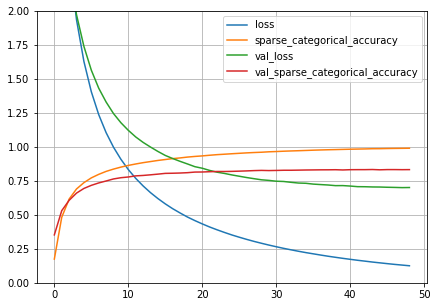

time: 161 ms (started: 2023-02-26 16:08:29 +00:00)


In [38]:
plot_loss(history)

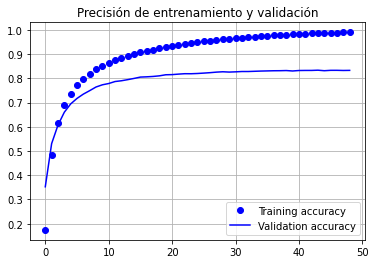

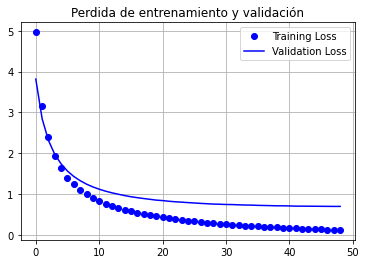

time: 254 ms (started: 2023-02-26 16:08:29 +00:00)


In [39]:
show_history(history)

In [40]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/regular/otsu_reg/model_densenet121_etl_8g_imgs112_regular__OTSU.h5
time: 863 ms (started: 2023-02-26 16:08:29 +00:00)


# Imgs 127x127

- Test Accuracy: 0.865270733833313
- Test Loss: 0.5653793215751648
- time: 59min 50s
- F1 score: 0.8658520674227566
- Precision score: 0.8753742507663622
- Recall:  0.8652707275803723
- Epoch: 50/50



## Cargar imágenes

In [41]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_127/splits/regular_otsu/
time: 727 µs (started: 2023-02-26 16:08:30 +00:00)


In [42]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 12.7 s (started: 2023-02-26 16:08:30 +00:00)


In [43]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 127, 127, 1) and labels: (106380,)

- val images: (21276, 127, 127, 1) and labels: (21276,)

time: 1.24 ms (started: 2023-02-26 16:08:43 +00:00)


## Preparar el modelo

In [44]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 2.97 s (started: 2023-02-26 16:08:43 +00:00)


In [45]:
print(custom_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 127, 127, 3)  0           ['input_4[0][0]',                
                                                                  'input_4[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 133, 133, 3)  0          ['concatenate_3[0][0]']    

## Entrenar modelo

In [46]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 81s 23ms/step - loss: 5.0026 - sparse_categorical_accuracy: 0.1850 - val_loss: 3.8196 - val_sparse_categorical_accuracy: 0.3654
Epoch 2/50
3325/3325 [==============================] - 72s 22ms/step - loss: 3.1437 - sparse_categorical_accuracy: 0.5107 - val_loss: 2.7794 - val_sparse_categorical_accuracy: 0.5608
Epoch 3/50
3325/3325 [==============================] - 72s 22ms/step - loss: 2.3351 - sparse_categorical_accuracy: 0.6460 - val_loss: 2.2182 - val_sparse_categorical_accuracy: 0.6444
Epoch 4/50
3325/3325 [==============================] - 72s 22ms/step - loss: 1.8587 - sparse_categorical_accuracy: 0.7172 - val_loss: 1.8649 - val_sparse_categorical_accuracy: 0.6920
Epoch 5/50
3325/3325 [==============================] - 72s 22ms/step - loss: 1.5457 - sparse_categorical_accuracy: 0.7611 - val_loss: 1.6239 - val_sparse_categorical_accuracy: 0.7267
Epoch 6/50
3325/3325 [==============================] - 72s 22ms/step - loss: 1.

## Graficando

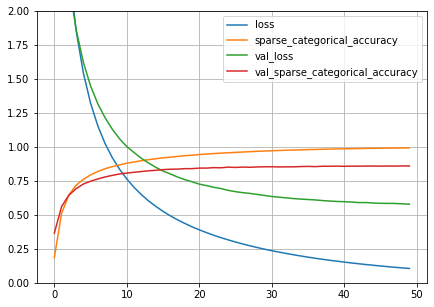

time: 148 ms (started: 2023-02-26 17:08:38 +00:00)


In [47]:
plot_loss(history)

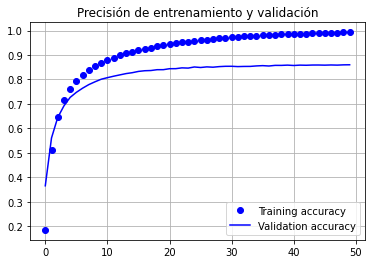

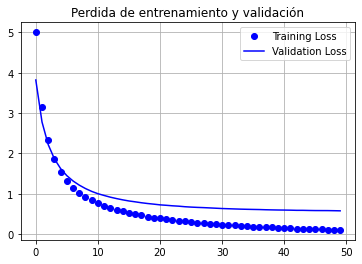

time: 251 ms (started: 2023-02-26 17:08:38 +00:00)


In [48]:
show_history(history)

In [49]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/regular/otsu_reg/model_densenet121_etl_8g_imgs127_regular__OTSU.h5
time: 886 ms (started: 2023-02-26 17:08:39 +00:00)


## Métricas

In [50]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.03 s (started: 2023-02-26 17:08:39 +00:00)


In [51]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 10s 17ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.865270733833313
- Test Loss: 0.5653793215751648
- time: 
- F1 score: 0.8658520674227566
- Precision score: 0.8753742507663622
- Recall:  0.8652707275803723
- Epoch: 
*********************************************************************************************************************************
time: 18.9 s (started: 2023-02-26 17:08:41 +00:00)


In [52]:
runtime.unassign()

time: 484 ms (started: 2023-02-26 17:09:00 +00:00)
